In [21]:
__maintainer__ = "[José M. Beltrán](<jobel.open.science@gmail.com>)"
__modified_from = {"code":"matlab","credits":"Shungudzemwoyo Garaba","email":"<shungu.garaba@uni-oldenburg.de>", "dates":{"created":20110224, "modified":20140910}}
__credits__ = ["José M. Beltrán, Tiago A. M. Silva"]
__license__ = "GPL-3.0"
__status__ = []
__creation_date__ = 20150319

# Notebook to calculate the Forel-Ule Index

It allows you to convert hyperspectral remote sensing data into the Forel-Ule color index.

The two articles will provide you with some updated information on the algorithm and constant parameters (FUI_ATAN2.dat or FUI_ATAN210.dat).

test.dat is the sample reflectance file

**References**:

Wernand, M. R., & van der Woerd, H. J. (2010). Spectral analysis of the Forel-Ule ocean colour comparator scale. Journal of the European Optical Society, 5. doi:10.2971/jeos.2010.10014s

Wernand, M. R., Hommersom, a., & Van Der Woerd, H. J. (2013). MERIS-based ocean colour classification with the discrete Forel-Ule scale. Ocean Science, 9, 477–487. doi:10.5194/os-9-477-2013

In [2]:
import os
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import math
import numpy as np

[**Notes from the colour and vision research laboratory**](http://www.cvrl.org/)

The CIE 1931 2-deg CMFs (CIE, 1932), which form the basis for most practical colorimetry, are based on the chromaticity coordinates obtained by Guild (1931) and by Wright (1928). Chromaticity coordinates, however, provide only a relative measure of the ratios of the three primaries needed to match each spectrum color, whereas CMFs specify absolute energy values. In order to reconstruct the CMFs from the Wright and Guild data, it was assumed that the CIE1924 V(l) photopic luminosity function (CIE, 1926) is a linear combination of the three CMFs (see Wyszecki & Stiles, 1982), for a description of the reconstruction and for the tabulated values. 

It has long been clear that the CIE1924 V(λ) that was used to construct the CIE 1931 2-deg CMFs **seriously underestimates sensitivity at wavelengths below 460 nm**, so that these CMFs are seriously in error at short wavelengths. The Judd and Judd-Vos modifications are attempts to overcome this problem.

The cmf used here are the CIE 1931 CMF with Judd and Vos corrections.

In [3]:
fui = {"discrete":pd.DataFrame(),"continuous":[]}
fui["continuous"] = pd.read_csv(sep = "\t", filepath_or_buffer = "data/FUI_ATAN210.tsv", names = ["value", "alpha"])
# see Table 3 of Wernand et al 2013 to refer to the angles, alpha, of FU number in degrees and
# the 20 boundary angles or colour transition angles, alpha_T, that are used in the discrete classification of ocean colour

fui["discrete"] = pd.read_csv(sep = "\t", filepath_or_buffer = "data/FUI_ATAN2.tsv", names = ["alpha","alpha_T","value"])

In [4]:
# Showing the first 5 rows in the dataframe
fui['discrete'][:5]

,alpha,alpha_T,value
0,229.943868,227.677431,1
1,225.410993,219.271054,2
2,213.131116,205.190884,3
3,197.250652,189.202645,4
4,181.154639,165.707958,5


### Colour matching functions (cmf) 

$\tilde{x}, \tilde{y}, \tilde{z}$

In [5]:
cmf = pd.read_csv(sep = "\t", filepath_or_buffer = "data/FUI_CIE1931_JV.tsv")

In [6]:
cmf

,wavelength,x,y,z
0,380,0.002690,2.000000e-04,1.226000e-02
1,385,0.005311,3.955600e-04,2.422200e-02
2,390,0.010781,8.000000e-04,4.925000e-02
3,395,0.020792,1.545700e-03,9.513500e-02
4,400,0.037981,2.800000e-03,1.740900e-01
...,...,...,...,...
85,805,0.000007,2.607600e-06,5.862600e-10
86,810,0.000005,1.836500e-06,4.213800e-10
87,815,0.000003,1.295000e-06,3.031900e-10
88,820,0.000002,9.109200e-07,2.175300e-10


Text(0.5, 1.0, 'Colour matching functions')

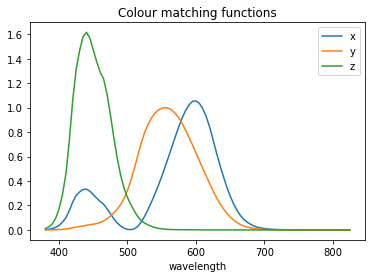

In [7]:
cmf.plot(x='wavelength', y=['x','y','z'], label=['x','y','z'])
plt.legend()
plt.title('Colour matching functions')

In [8]:
test = pd.read_csv(sep = "\t", filepath_or_buffer = "data/test.csv", header = None)
# Renaming the columns of the test dataframe
test.columns = ["wavelength", "y1", "y2", "y3", "y4"]
#test['y1'] = np.cos(test['y1']/0.0175)

**From Wernand et al (2010):**

`"The chromaticity coordinates, based on transmission measurements, of the FU scale and the basic solutions. The white refers to the coordinates equal to 1/3"`

The transmission measurements used a TrIOS spectroradiometer with 4 nm band resolution.

**From Wernand et al (2013):**

`"Because MERIS does not provide full-spectral range coverage, the reflection spectrum is first reconstructed by linear interpolation between band n=1 (412.5 nm) and band n=9 (708) with a resolution of 1 nm"`

In [9]:
#the interpolating part 
Delta_lambda = 5 # 1nm bins
# adds +4 as it should include 720 resulting in 86 values, i.e. matching the len(cmf).
iwavelength = np.array(range(380, 720 + Delta_lambda, Delta_lambda)) 


In [10]:
# retrieving the reflectance values for lambda 380-720nm
irho = interp1d(test["wavelength"], test["y1"], kind = 'linear')(iwavelength)

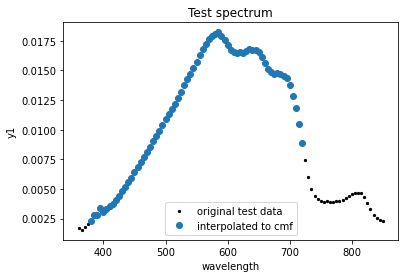

In [11]:
test.plot(x='wavelength', y='y1', kind='scatter', marker ='.', c='k')
plt.plot(iwavelength, irho, 'o')
plt.title('Test spectrum')
plt.legend(['original test data','interpolated to cmf'])

In [12]:
# find overping wavelengths between cmf and multispectral image
start = max([cmf['wavelength'].iloc[0], iwavelength.min()])
end = min([cmf['wavelength'].iloc[-1], iwavelength.max()])
print('wavelength overlap', start,end)
cmf = cmf[ (cmf['wavelength'] >= start) & (cmf['wavelength'] <= end) ]

wavelength overlap 380 720


# Calculating the tristimulus values for X, Y and Z by Riemann sum approximation of the integrals with $\Delta\lambda$ = 1 nm

$$
X = \sum_{i=413}^{708} [\rho_w]_N(\lambda_i)\tilde{x}(\lambda)\Delta\lambda \\
Y = \sum_{i=413}^{708} [\rho_w]_N(\lambda_i)\tilde{y}(\lambda)\Delta\lambda \\
Z = \sum_{i=413}^{708} [\rho_w]_N(\lambda_i)\tilde{z}(\lambda)\Delta\lambda
$$

In [13]:
# Creating a dictionary to hold the reflectance values aas tristimulus
r = {"X": [], "Y": [], "Z": []}
# ------- R_RS * cmf
for i in range(0, len(cmf)):
    r["X"] = irho * cmf["x"]
    r["Y"] = irho * cmf["y"]
    r["Z"] = irho * cmf["z"]

In [14]:
# ------ Sum
s = {"X": [], "Y": [], "Z": []}

s["X"] = sum(r["X"] * Delta_lambda)
s["Y"] = sum(r["Y"] * Delta_lambda)
s["Z"] = sum(r["Z"] * Delta_lambda)

sum_xyz = s["X"] + s["Y"] + s["Z"]

In [15]:
# ------ chromaticity
chrom = {"x": [], "y": [], "z": []}
chrom["x"] = s["X"] / sum_xyz
chrom["y"] = s["Y"] / sum_xyz
chrom["z"] = s["Z"] / sum_xyz

sum_chrom_y = chrom["x"] + chrom["y"] + chrom["z"]

In [16]:
# ______ chromaticity - whiteness
chrom_w = {"x": [], "y": []}
chrom_w["x"] = chrom["x"] - (1 / 3)
chrom_w["y"] = chrom["y"] - (1 / 3)

In [17]:
# ______ calculate atan2
# we use the average atan per scale
# a_i, refers to the alpha M angle
a_i = math.atan2(chrom_w["y"], chrom_w["x"]) * 180 / math.pi

if a_i < 0:
    a_i = a_i + 360
else:
    a_i = a_i

In [18]:
# ----- fui approximation

if a_i >= fui["continuous"]["alpha"][0]:  # FUI = 1 its > Average
    fu_i = 1.0
elif math.isnan(a_i):  # FUI = NAN = 0
    fu_i = 0
elif a_i <= fui["continuous"]["alpha"][200]:  # FUI = 21
    fu_i = 21.0
else:
    for c in range(0, 200):
        if (fui["continuous"]["alpha"][c] > a_i) and (a_i >= fui["continuous"]["alpha"][c + 1]):
            fu_i = fui["continuous"]["value"][c + 1]

In [19]:
# The calculated FUI is
fu_i

18.1